# Import and definitions

In [1]:
"""General clean OC script."""

import numpy as np
import tensorflow as tf
from scipy.linalg import expm
import copy

import c3po.component as component
import c3po.generator as generator
import c3po.hamiltonians as hamiltonians
import c3po.envelopes as envelopes
import c3po.control as control
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.optimizer import Optimizer as Opt
from c3po.experiment import Experiment as Exp
from c3po.utils import log_setup
from c3po.tf_utils import tf_abs, tf_ave
from c3po.tf_utils import tf_limit_gpu_memory as tf_limit_gpu_memory
from c3po.qt_utils import basis, xy_basis, perfect_gate

In [2]:
def create_gates(t_final, v_hz_conversion, qubit_freq, qubit_anhar=None):
    """
    Define the atomic gates.

    Parameters
    ----------
    t_final : type
        Total simulation time == longest possible gate time.
    v_hz_conversion : type
        Constant relating control voltage to energy in Hertz.
    qubit_freq : type
        Qubit frequency. Determines the carrier frequency.
    qubit_anhar : type
        Qubit anharmonicity. DRAG is used if this is given.

    """
    gauss_params = {
        'amp': 0.7 * np.pi / v_hz_conversion,  # Slightly off from ideal 0.5
        't_final': t_final,
        'xy_angle': 0.0,
        'freq_offset': 5e6 * 2 * np.pi,  # Slightly off from ideal 0
        'delta': 1 / qubit_anhar
    }
    gauss_bounds = {
        'amp': [0.01 * np.pi / v_hz_conversion, 1.5 * np.pi / v_hz_conversion],
        't_final': [1e-9, 30e-9],
        'xy_angle': [-1 * np.pi/2, 1 * np.pi/2],
        'freq_offset': [-100 * 1e6 * 2 * np.pi, 100 * 1e6 * 2 * np.pi],
        'delta': [10/qubit_anhar, 0.1/qubit_anhar]
    }

    gauss_env = control.Envelope(
        name="gauss",
        desc="Gaussian comp 1 of signal 1",
        params=gauss_params,
        bounds=gauss_bounds,
        shape=envelopes.gaussian
    )
    carrier_parameters = {
        'freq': qubit_freq
    }
    carrier_bounds = {
        'freq': [4e9 * 2 * np.pi, 7e9 * 2 * np.pi]
    }
    carr = control.Carrier(
        name="carrier",
        desc="Frequency of the local oscillator",
        params=carrier_parameters,
        bounds=carrier_bounds
    )
    X90p = control.Instruction(
        name="X90p",
        t_start=0.0,
        t_end=t_final,
        channels=["d1"]
    )
    X90p.add_component(gauss_env, "d1")
    X90p.add_component(carr, "d1")

    gates = control.GateSet()
    gates.add_instruction(X90p)
        
    # Define more gates accordingly:
    #
    # Y90p = copy.deepcopy(X90p)
    # Y90p.name = "Y90p"
    # Y90p.comps['d1']['gauss'].params['xy_angle'] = np.pi / 2
    # Y90p.comps['d1']['gauss'].bounds['xy_angle'] = [0 * np.pi/2, 2 * np.pi/2]
    #
    # X90m = copy.deepcopy(X90p)
    # X90m.name = "X90m"
    # X90m.comps['d1']['gauss'].params['xy_angle'] = np.pi
    # X90m.comps['d1']['gauss'].bounds['xy_angle'] = [1 * np.pi/2, 3 * np.pi/2]
    #
    # Y90m = copy.deepcopy(X90p)
    # Y90m.name = "Y90m"
    # Y90m.comps['d1']['gauss'].params['xy_angle'] = - np.pi / 2
    # Y90m.comps['d1']['gauss'].bounds['xy_angle'] = [-2 * np.pi/2, 0 * np.pi/2]
    #
    # gates.add_instruction(X90m)
    # gates.add_instruction(Y90m)
    # gates.add_instruction(Y90p)
    return gates


def create_chip_model(qubit_freq, qubit_anhar, qubit_lvls, drive_ham):
    q1 = component.Qubit(
        name="Q1",
        desc="Qubit 1",
        comment="The one and only qubit in this chip",
        freq=qubit_freq,
        anhar=qubit_anhar,
        hilbert_dim=qubit_lvls
    )
    drive = component.Drive(
        name="D1",
        desc="Drive 1",
        comment="Drive line 1 on qubit 1",
        connected=["Q1"],
        hamiltonian=drive_ham
    )
    chip_elements = [q1, drive]
    model = Mdl(chip_elements)
    return model


# Devices and generator
def create_generator(sim_res, awg_res, v_hz_conversion, logdir):
    lo = generator.LO(resolution=sim_res)
    awg = generator.AWG(resolution=awg_res, logdir=logdir)
    mixer = generator.Mixer()
    v_to_hz = generator.Volts_to_Hertz(V_to_Hz=v_hz_conversion)
    dig_to_an = generator.Digital_to_Analog(resolution=sim_res)
    resp = generator.Response(rise_time=0.1e-9, resolution=sim_res)
    devices = [lo, awg, mixer, v_to_hz, dig_to_an, resp]
    gen = generator.Generator(devices)
    return gen

In [3]:
logdir = log_setup("/tmp/c3logs/")

# System
qubit_freq = 5e9 * 2 * np.pi
qubit_anhar = -250e6 * 2 * np.pi
qubit_lvls = 4
drive_ham = hamiltonians.x_drive
v_hz_conversion = 1
t_final = 25e-9

# Resolutions
sim_res = 250e9
awg_res = 1e9

# Create system
model = create_chip_model(qubit_freq, qubit_anhar, qubit_lvls, drive_ham)
gen = create_generator(sim_res, awg_res, v_hz_conversion, logdir=logdir)
gates = create_gates(t_final, v_hz_conversion, qubit_freq, qubit_anhar)

# Enable this to automatically use DRAG corrections
#gen.devices['awg'].options = 'drag'

# Simulation class and fidelity function
exp = Exp(model, gen)
sim = Sim(exp, gates)
a_q = model.ann_opers[0]

# Virtual Z rotations
sim.VZ = expm(1.0j * np.matmul(a_q.T.conj(), a_q) * qubit_freq * t_final)

# Define states & unitaries
ket_0 = tf.constant(basis(qubit_lvls, 0), dtype=tf.complex128)
bra_2 = tf.constant(basis(qubit_lvls, 2).T, dtype=tf.complex128)
bra_yp = tf.constant(xy_basis(qubit_lvls, 'yp').T, dtype=tf.complex128)
X90p = tf.constant(perfect_gate(qubit_lvls, 'X90p'), dtype=tf.complex128)

In [4]:
def state_transfer_infid(U_dict: dict):
    U = U_dict['X90p']
    ket_actual = tf.matmul(U, ket_0)
    overlap = tf_abs(tf.matmul(bra_yp, ket_actual))
    infid = 1 - overlap
    return infid

def unitary_infid(U_dict: dict):
    U = U_dict['X90p']
    unit_fid = tf_abs(
                tf.linalg.trace(
                    tf.matmul(U, tf.linalg.adjoint(X90p))
                    ) / 2
                )**2
    infid = 1 - unit_fid
    return infid

def pop_leak(U_dict: dict):
    U = U_dict['X90p']
    ket_actual = tf.matmul(U, ket_0)
    overlap = tf_abs(tf.matmul(bra_2, ket_actual))
    return overlap

# Optimizer object
opt = Opt(data_path=logdir)

This map defines which parameters to optmize. The rest will be fixed.

In [5]:
opt_map = [
    [('X90p', 'd1', 'gauss', 'amp')],
    [('X90p', 'd1', 'gauss', 'freq_offset')],
    [('X90p', 'd1', 'gauss', 'xy_angle')],
    # [('X90p', 'd1', 'gauss', 'delta')] # This is a DRAG parameter.
]

Run the optimization

In [6]:
opt.optimize_controls(
    sim=sim,
    opt_map=opt_map,
    opt='lbfgs',
    opt_name='openloop',
    fid_func=unitary_infid
)

Saving as:
/tmp/c3logs/2019_11_13_T_14_56_38/openloop.log


# Plotting

You can run the below in a different kernel to get a live plot. Or look a the log e.g.

$ less /tmp/c3logs/recent/openloop.log

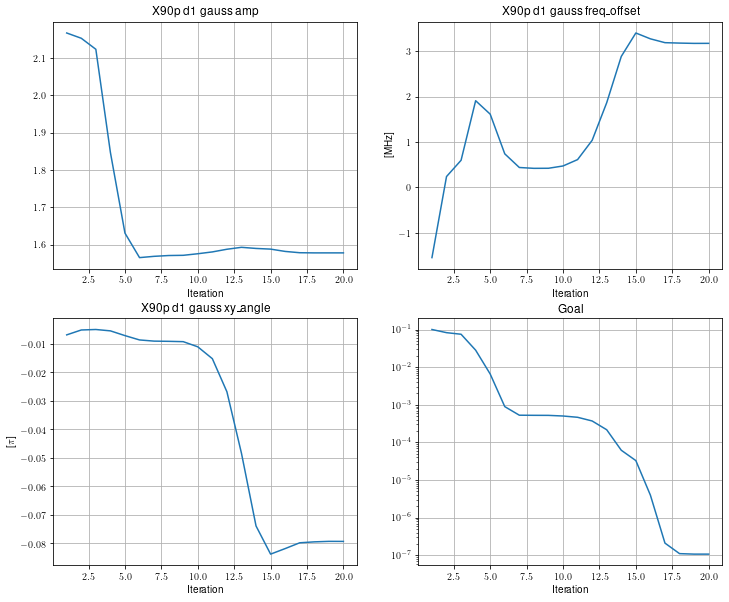

In [7]:
from c3po.display import plot_OC_logs
plot_OC_logs("/tmp/c3logs/recent/openloop.log")